In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import os
from tqdm import tqdm_notebook
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

%matplotlib inline

In [137]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [187]:
df1 = pd.read_json("parser/rt_dump.json", encoding="utf-8")
df2 = pd.read_json("parser/dni_dump.json", encoding="utf-8")
df3 = pd.read_json("parser/meduza_dump.json", encoding="utf-8")

In [188]:
df_full = pd.concat([df1, df2, df3], ignore_index=True)

In [189]:
df_full.to_json("news_dump_fix.json")

In [190]:
df_full = pd.read_json("news_dump_fix.json", encoding="utf-8")

In [191]:
df_full=df_full.reset_index(drop=True)

In [192]:
df_full[df_full["body"]==""].shape[0]

12

In [193]:
df_full[df_full["body"]==""]

,body,id,source,title
206,,https://meduza.io/shapito/2018/10/30/vse-kradu...,Meduza,Все крадут картонную Ольгу Бузову из «Пятерочк...
286,,https://meduza.io/short/2018/10/29/proschanie-...,Meduza,Прощание с Николаем Караченцовым в «Ленкоме». ...
761,,https://dni.ru/society/2018/10/30/410326.html,Dni.ru,\t\t\t\t\t\t\tАмериканский подрывник хотел уб...
765,,https://dni.ru/regions/2018/10/30/410320.html,Dni.ru,\t\t\t\t\t\t\tПоимка террористов в Татарстане ...
819,,https://dni.ru/showbiz/2018/10/29/410274.html,Dni.ru,\t\t\t\t\t\t\tКомпозитор Бородин погиб в ДТП\t...
844,,https://dni.ru/society/2018/10/29/410248.html,Dni.ru,\t\t\t\t\t\t\tВ Москве памятники покраснели из...
970,,https://meduza.io/short/2018/11/12/raketnyy-ob...,Meduza,Ракетный обстрел Израиля из сектора Газа. Фото...
1024,,https://meduza.io/short/2018/11/11/prezident-r...,Meduza,Президент России у памятника солдатам Русского...
1025,,https://meduza.io/short/2018/11/11/prezident-f...,Meduza,Президент Франции Эмманюэль Макрон и канцлер Ф...
1026,,https://meduza.io/short/2018/11/11/fanaty-lest...,Meduza,Фанаты «Лестера» простились с погибшим владель...


In [194]:
df_full[df_full["body"]==""]["id"].tolist()

['https://meduza.io/shapito/2018/10/30/vse-kradut-kartonnuyu-olgu-buzovu-iz-pyaterochki-nu-ladno',
 'https://meduza.io/short/2018/10/29/proschanie-s-nikolaem-karachentsovym-v-lenkome-fotografiya',
 'https://dni.ru/society/2018/10/30/410326.html',
 'https://dni.ru/regions/2018/10/30/410320.html',
 'https://dni.ru/showbiz/2018/10/29/410274.html',
 'https://dni.ru/society/2018/10/29/410248.html',
 'https://meduza.io/short/2018/11/12/raketnyy-obstrel-izrailya-iz-sektora-gaza-fotografiya',
 'https://meduza.io/short/2018/11/11/prezident-rossii-u-pamyatnika-soldatam-russkogo-ekspeditsionnogo-korpusa-vo-frantsii-fotografiya-s-tseremonii-pamyati-zhertv-pervoy-mirovoy',
 'https://meduza.io/short/2018/11/11/prezident-frantsii-emmanuel-makron-i-kantsler-frg-otmechayut-100-letie-okonchaniya-pervoy-mirovoy-fotografiya',
 'https://meduza.io/short/2018/11/11/fanaty-lestera-prostilis-s-pogibshim-vladeltsem-komandy-fotografiya',
 'https://meduza.io/short/2018/11/07/eto-moy-krik-dushi-zurab-tsereteli-otk

Это короткие материалы медузы, в них обычно главное не текст, а картинка/видео с описанием

In [195]:
df_full = df_full[df_full["body"]!=""]
df_full["label"] = df_full["source"].apply(lambda x : 1 if x=="Dni.ru" else 0)
df_full.head()

,body,id,source,title,label
0,Клуб Континентальной хоккейной лиги (КХЛ) «...,https://russian.rt.com/sport/news/572018-hokke...,RT,Хоккейный «Спартак» начнёт следующий сезон на ...,0
1,Генеральный прокурор Украины Юрий Луценко за...,https://russian.rt.com/ussr/news/572020-lucenk...,RT,Луценко заявил об отсутствии результатов рассл...,0
2,После матча 14-го тура Российской премьер-ли...,https://russian.rt.com/sport/news/572025-konon...,RT,"Кононов рассказал, возглавит ли он «Спартак»",0
3,Пожарным удалось ликвидировать открытое горени...,https://russian.rt.com/russia/news/572122-mchs...,RT,Пожарные ликвидировали открытое горение в гипе...,0
4,В Новой Каледонии — заморской территории Фра...,https://meduza.io/news/2018/11/04/storonniki-n...,Meduza,Сторонники независимости от Франции проиграли ...,0


In [196]:
df_full["len"] = df_full["body"].apply(lambda x : len(x))

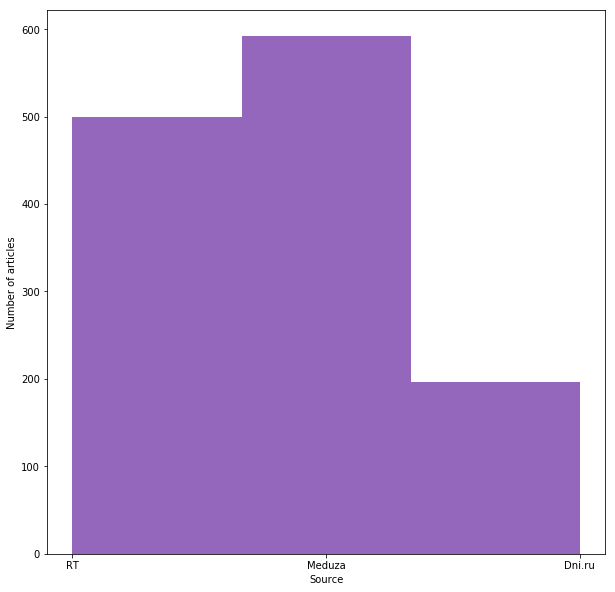

In [197]:
fig = plt.figure(figsize=(10, 10))
plt.hist(df_full["source"].tolist(), bins=3, color="tab:purple")
plt.xlabel("Source")
plt.ylabel("Number of articles")
plt.show()

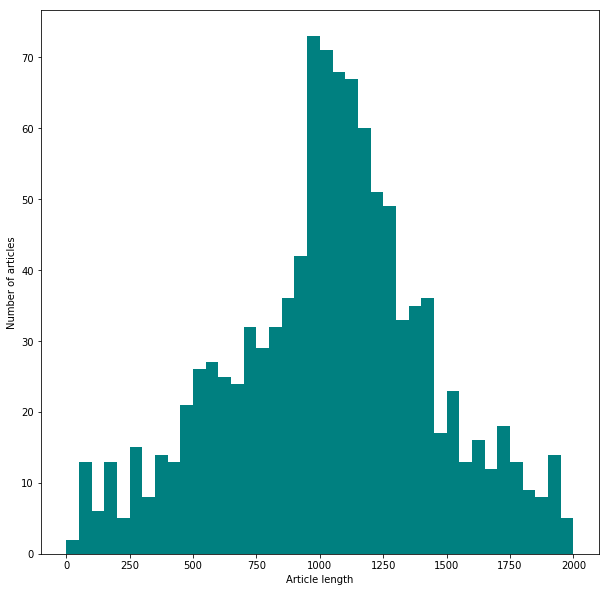

In [198]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Article length')
plt.ylabel('Number of articles')
plt.hist(df_full["len"].tolist(), bins=40, range=(0, 2000), color="teal")
plt.show()

## Data preprocessing

In [199]:
table = str.maketrans('', '', string.punctuation)

In [200]:
import nltk

In [201]:
m = Mystem()

In [202]:
def beautify(text):
    pbar.update(1)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r"#(\w+)", '', text)
    text = re.sub(r"@(\w+)", '', text)
    text = re.sub(r"–", '', text)
    text = re.sub(r"[«»]", '', text)
    words = text.split()
    stripped = " ".join([w.translate(table).lower() for w in words])
    stemmed = m.lemmatize(stripped)
    return "".join(stemmed)

In [203]:
df_full[df_full.source=="Dni.ru"]["body"].tolist()[0]

'Продолжение: Акинфеев рассказал о дедовщине в ЦСКА Игорь Акинфеев признался,\r\nчто думал о завершении выступлений за национальную команду после ЧМ-2018, но не\r\nбуквально с финальным свистком. По словам спортсмена, точку в этом\r\nвопросе поставило обследование в Германии. Прощай, Россия: Игорь Акинфеев завершил карьеру Черчесов оправдался за "отставку" Акинфеева и Смолова "Мы основательно говорили\r\nс доктором и пришли к выводу, что нельзя играть на два фронта. Многие говорят, почему я ждал два месяца – все из-за\r\nобследования, после него я поставил жирную точку в своей карьере в сборной", – рассказал Акинфеев в программе "Футбол России"\r\nна "России 24". Футболист отметил, что не жалеет о своем решении. "Я играл в сборной 15 лет, они были\r\nхорошими и плохими, но это срок. Для меня важно, что такую долгую карьеру я\r\nпровел в сборной", – добавил голкипер. Также он признался, что не смотрит\r\nфутбол по телевизору, лишь некоторые сокращенные обзоры, чтобы быть в курсе\r

In [204]:
beautify(df_full[df_full.source=="Dni.ru"]["body"].tolist()[0])

'продолжение акинфей рассказывать о дедовщина в цска игорь акинфей признаваться что думать о завершение выступление за национальный команда после чм2018 но не буквально с финальный свисток по слово спортсмен точка в этот вопрос поставлять обследование в германия прощать россия игорь акинфей завершать карьера черчесов оправдываться за отставка акинфеев и смолова мы основательно говорить с доктор и приходить к вывод что нельзя играть на два фронт многие говорить почему я ждать два месяц все изза обследование после он я поставлять жирный точка в свой карьера в сборная рассказывать акинфей в программа футбол россия на россия 24 футболист отмечать что не жалеть о свой решение я играть в сборная 15 год они быть хороший и плохой но это срок для я важный что такой долгий карьера я проводить в сборная добавлять голкипер также он признаваться что не смотреть футбол по телевизор лишь некоторый сокращенный обзор чтобы быть в курс происходить посмотреть этот публикация в instagram публикация от иго

In [205]:
pbar = tqdm_notebook(total = df_full.shape[0])

In [206]:
df_full["body_norm"] = df_full["body"].apply(beautify)

In [208]:
df_full.head()

,body,id,source,title,label,len,body_norm
0,Клуб Континентальной хоккейной лиги (КХЛ) «...,https://russian.rt.com/sport/news/572018-hokke...,RT,Хоккейный «Спартак» начнёт следующий сезон на ...,0,1171,клуб континентальный хоккейный лига кхл спарта...
1,Генеральный прокурор Украины Юрий Луценко за...,https://russian.rt.com/ussr/news/572020-lucenk...,RT,Луценко заявил об отсутствии результатов рассл...,0,1078,генеральный прокурор украина юрий луценко заяв...
2,После матча 14-го тура Российской премьер-ли...,https://russian.rt.com/sport/news/572025-konon...,RT,"Кононов рассказал, возглавит ли он «Спартак»",0,1071,после матч 14го тур российский премьерлига с м...
3,Пожарным удалось ликвидировать открытое горени...,https://russian.rt.com/russia/news/572122-mchs...,RT,Пожарные ликвидировали открытое горение в гипе...,0,906,пожарный удаваться ликвидировать открытый горе...
4,В Новой Каледонии — заморской территории Фра...,https://meduza.io/news/2018/11/04/storonniki-n...,Meduza,Сторонники независимости от Франции проиграли ...,0,705,в новый каледония — заморский территория франц...


In [209]:
pbar = tqdm_notebook(total = df_full.shape[0])
df_full["title_norm"] = df_full["title"].apply(beautify)

In [210]:
df_full.head()

,body,id,source,title,label,len,body_norm,title_norm
0,Клуб Континентальной хоккейной лиги (КХЛ) «...,https://russian.rt.com/sport/news/572018-hokke...,RT,Хоккейный «Спартак» начнёт следующий сезон на ...,0,1171,клуб континентальный хоккейный лига кхл спарта...,хоккейный спартак начинать следующий сезон на ...
1,Генеральный прокурор Украины Юрий Луценко за...,https://russian.rt.com/ussr/news/572020-lucenk...,RT,Луценко заявил об отсутствии результатов рассл...,0,1078,генеральный прокурор украина юрий луценко заяв...,луценко заявлять об отсутствие результат рассл...
2,После матча 14-го тура Российской премьер-ли...,https://russian.rt.com/sport/news/572025-konon...,RT,"Кононов рассказал, возглавит ли он «Спартак»",0,1071,после матч 14го тур российский премьерлига с м...,кононов рассказывать возглавлять ли он спартак\n
3,Пожарным удалось ликвидировать открытое горени...,https://russian.rt.com/russia/news/572122-mchs...,RT,Пожарные ликвидировали открытое горение в гипе...,0,906,пожарный удаваться ликвидировать открытый горе...,пожарный ликвидировать открытый горение в гипе...
4,В Новой Каледонии — заморской территории Фра...,https://meduza.io/news/2018/11/04/storonniki-n...,Meduza,Сторонники независимости от Франции проиграли ...,0,705,в новый каледония — заморский территория франц...,сторонник независимость от франция проигрывать...


In [211]:
bodys = df_full["body_norm"].tolist()
titles = df_full["title_norm"].tolist()

In [212]:
tfidf = TfidfVectorizer(min_df=0.002, max_df=0.9, ngram_range=(1,2))

In [213]:
bodys_tfidf = tfidf.fit_transform(bodys)

In [214]:
bodys_tfidf.shape

(1288, 16753)

In [215]:
titles_tfidf = tfidf.transform(titles)

In [216]:
titles_tfidf.shape

(1288, 16753)

Сделай дамп обеих матриц

In [217]:
np.save("titles_tfidf", titles_tfidf)
np.save("bodys_tfidf", bodys_tfidf)

# Super Dummy Approach

Классификация кликбейтных заголовков 

In [231]:
X_train, X_test, y_train, y_test = train_test_split(titles_tfidf, df_full["label"].tolist(), test_size=0.2)

In [232]:
lr = LogisticRegression(solver='sag', verbose=2, C=10)

In [233]:
lr.fit(X_train, y_train)

convergence after 40 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False)

In [234]:
lr.score(X_test, y_test)

0.8875968992248062

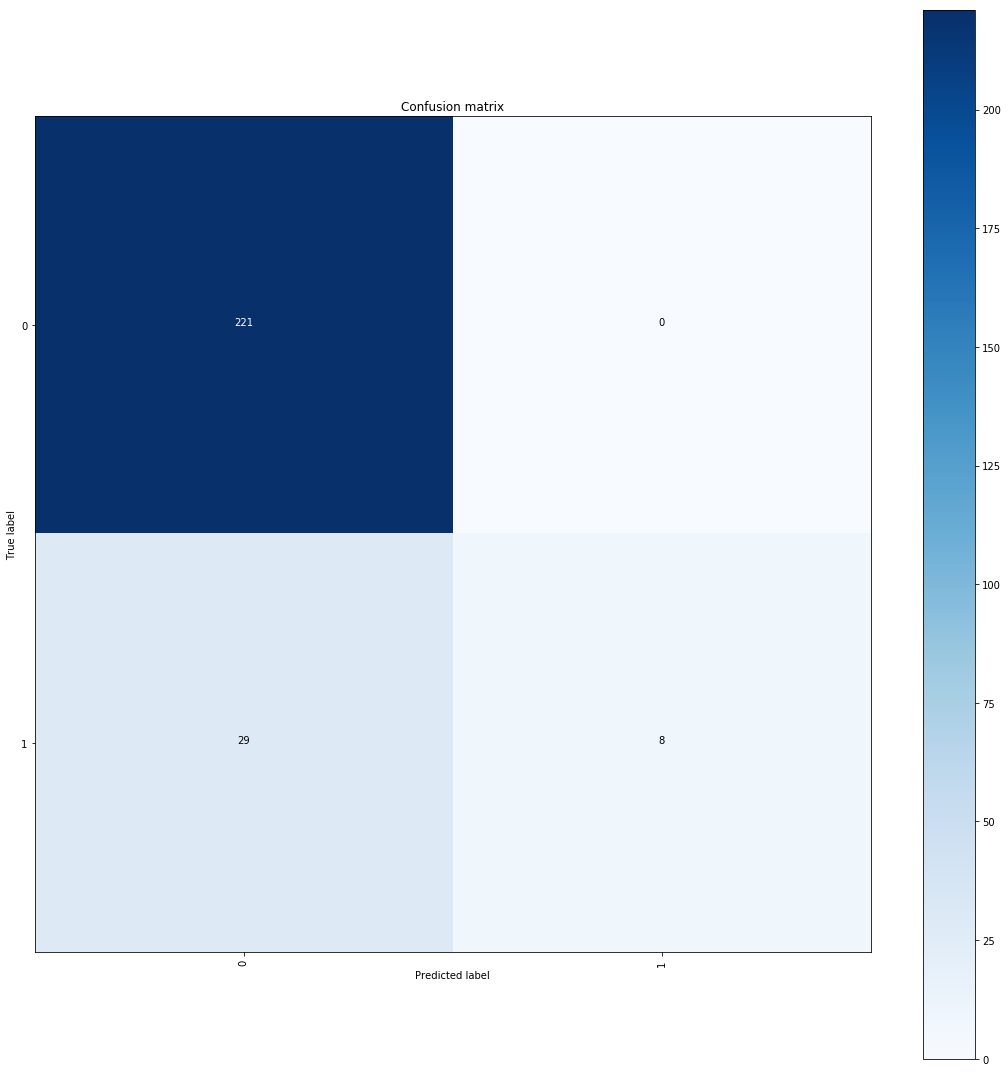

In [235]:
plot_confusion_matrix(confusion_matrix(y_test, lr.predict(X_test)), classes=lr.classes_)

In [237]:
X_test.shape[0]

258

In [238]:
df_full["preds_header"] = lr.predict(titles_tfidf)

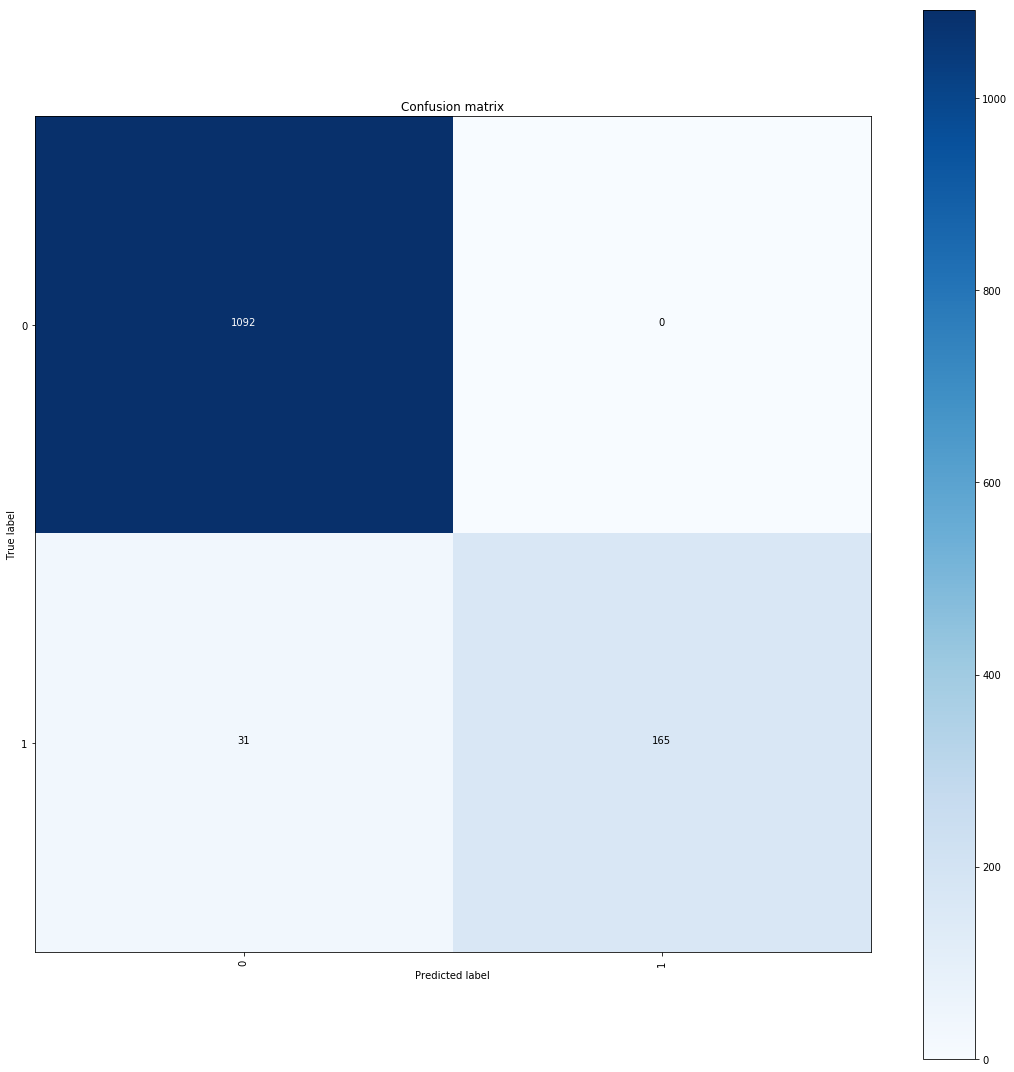

In [239]:
plot_confusion_matrix(confusion_matrix(df_full["label"], df_full["preds_header"]), classes=lr.classes_)

In [255]:
f1_score(df_full["label"], df_full["preds_header"])

0.9141274238227147

In [242]:
df_fail_header = df_full[df_full["label"]!=df_full["preds_header"]]

In [243]:
df_fail_header.to_csv("failed_header.csv", columns=["body", "id", "source", "title", "label", "preds_header"])

# Dummy Approach: Article-Header Cosine Similarity

In [244]:
similarities = [cosine_similarity(body, title)[0] for body, title in zip(bodys_tfidf, titles_tfidf)]

In [245]:
np.save("similarities", similarities)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(similarities, df_full["label"].tolist(), test_size=0.2)

In [247]:
lr = LogisticRegression(solver='sag', verbose=2, C=10)

In [248]:
lr.fit(X_train, y_train)

convergence after 23 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False)

In [249]:
lr.score(X_test, y_test)

0.8488372093023255

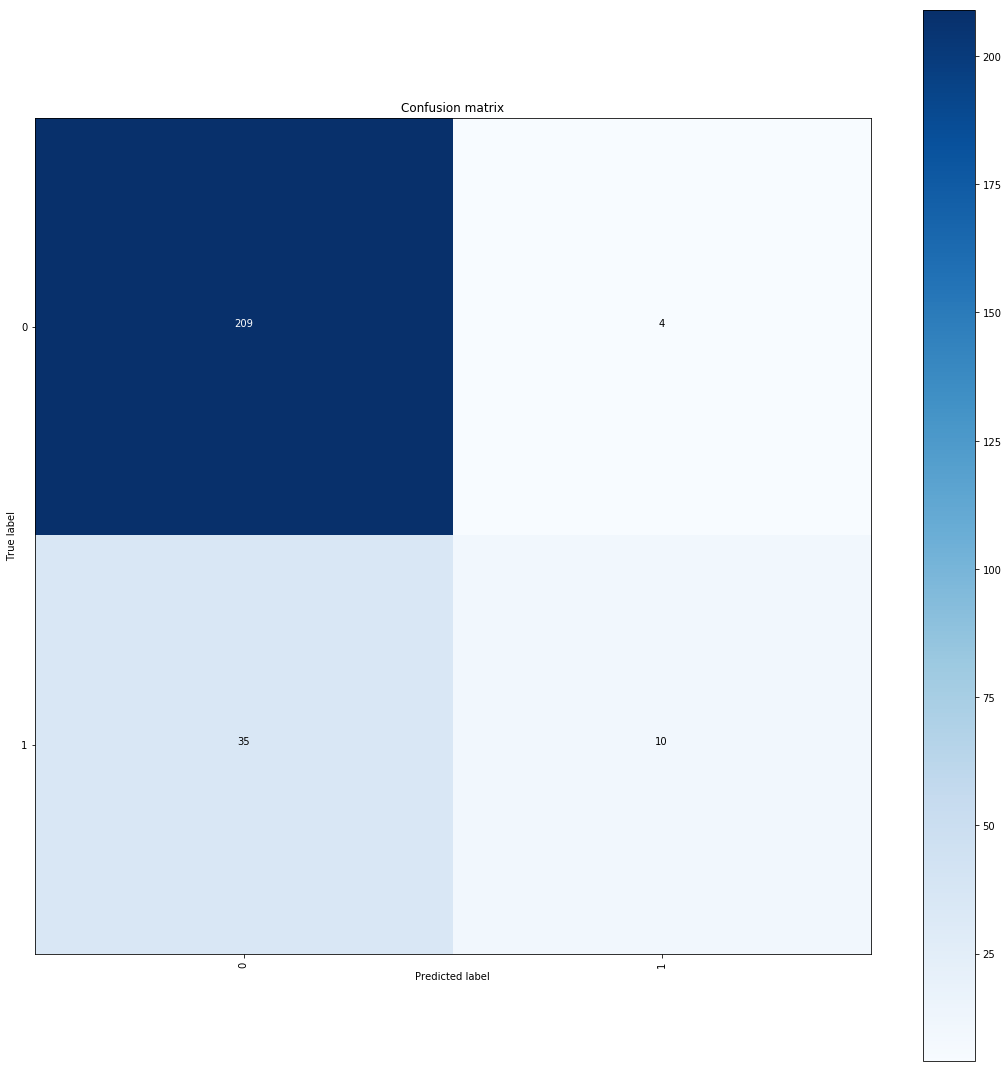

In [250]:
plot_confusion_matrix(confusion_matrix(y_test, lr.predict(X_test)), classes=lr.classes_)

In [251]:
preds = lr.predict(similarities)

In [252]:
df_full["preds_sim"] = preds

In [253]:
accuracy_score(df_full["label"], df_full["preds_sim"])

0.8664596273291926

In [254]:
f1_score(df_full["label"], df_full["preds_sim"])

0.3333333333333333

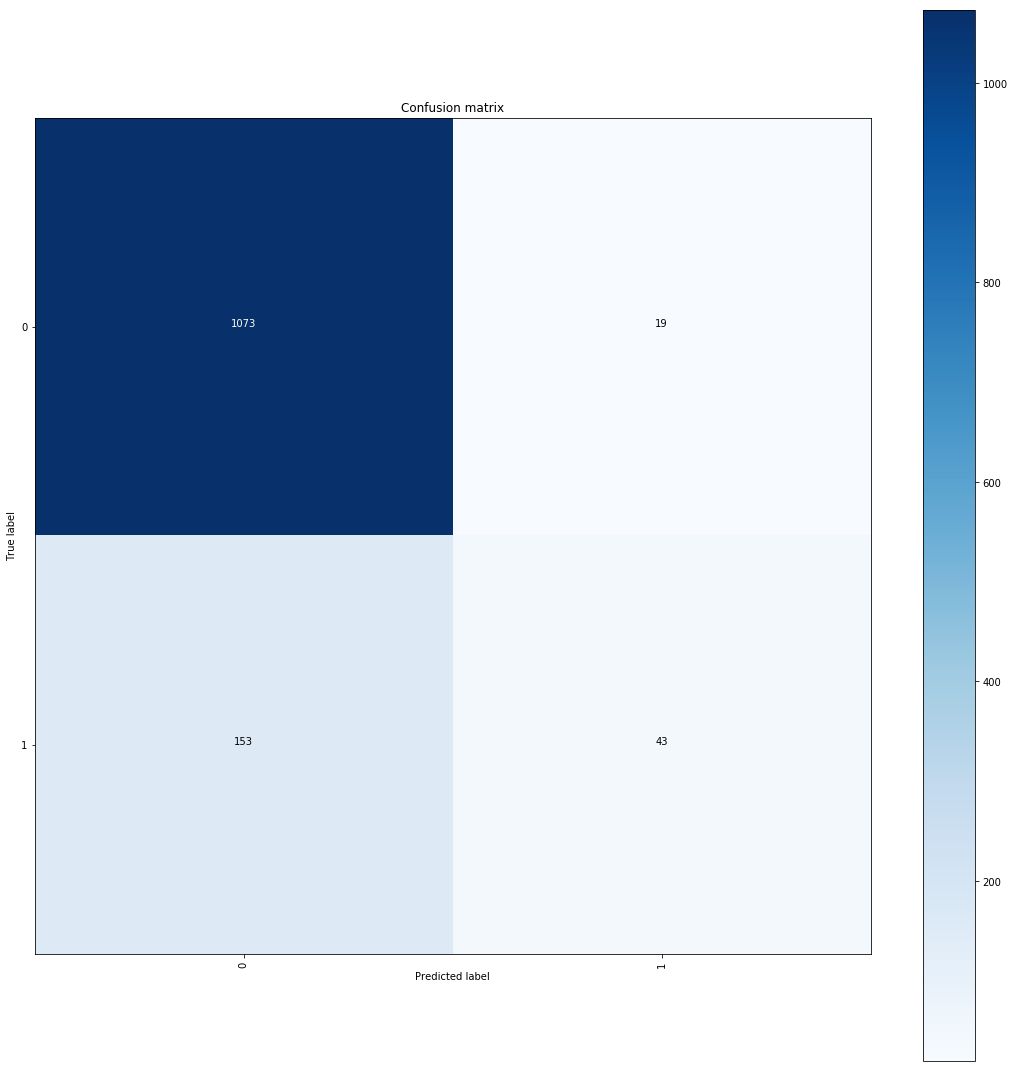

In [256]:
plot_confusion_matrix(confusion_matrix(df_full["label"], df_full["preds_sim"]), classes=lr.classes_)

In [259]:
df_fail = df_full[df_full["preds_sim"]!=df_full["label"]]
df_fail = df_fail[["body", "id", "source", "title", "label", "preds_sim"]]

In [260]:
print(df_fail.shape)
df_fail.head()

(172, 6)


,body,id,source,title,label,preds_sim
72,В Баренцевом море кто-то напал на американскую...,https://meduza.io/paragraph/2018/11/02/etot-fi...,Meduza,"Этот фильм запретили на Украине, ему не дают п...",0,1
124,Фото в анонсе: Владимир Астапкович / Sputnik /...,https://meduza.io/short/2018/11/01/eto-uhodyas...,Meduza,«Это уходящая натура». Замминистра связи — о б...,0,1
152,Фото в анонсе: BestPhotoPlus / Shutterstock.com,https://meduza.io/short/2018/10/31/minkomsvyaz...,Meduza,Минкомсвязи посоветовало россиянам подарить ци...,0,1
204,Фото в анонсе: Nozim Kalandarov / Reuters / Sc...,https://meduza.io/short/2018/10/30/radabon-i-d...,Meduza,Таджикистан вернет воинские звания времен импе...,0,1
205,Фото в анонсе: Максим Кимерлинг / ТАСС / Scanp...,https://meduza.io/short/2018/10/30/pochemu-fsi...,Meduza,Почему ФСИН не просит прощения за сталинские р...,0,1


In [261]:
df_fail.to_csv("sim_lr_fail.csv")

In [ ]:
df_fail[]

In [178]:
df_full.drop_duplicates().shape

(719, 9)

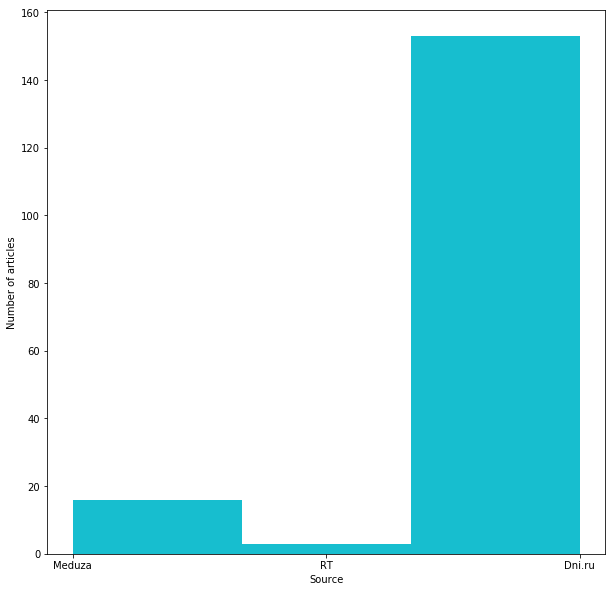

In [265]:
fig = plt.figure(figsize=(10, 10))
plt.hist(df_fail.drop_duplicates()["source"].tolist(), bins=3, color="tab:cyan")
plt.xlabel("Source")
plt.ylabel("Number of articles")
plt.show()